# My first little ML project
It aims to make predictions if a news is good or fake.

About the dataset:

1. id: each news has an associated unique id 
2. title: simply the title of the news
3. author: simply the author of the news
4. text: the text of the article (it could be incomplete!)
5. label: it marks if the news article is real (0) or fake (1)

In [2]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tesei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
print(stopwords.words('english')) #just printing the stopworkds in english

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Let's start here the data pre-processing

In [5]:
# loading the dataset to our pandas dataframe
df = pd.read_csv('train.csv')

df.shape
# after having seen the dimension of our dataset, as a matrix, let's print the first 5 rovws
print(df.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


In [6]:
# Counting the missing values in the dataset
df.isnull().sum() # this counts the number of missing values (through .isnull) in each column (by .sum()) 

id           0
title      558
author    1957
text        39
label        0
dtype: int64

As a first observation, we notice that, unfortunately, some values are missing in our real-or-fake-news dataset. We can read, in fact, that 558 titles and 1957 authors are missing, as well as 39 texts; we should then fill these values. By the way, since our principal variable - being the label - has not null values, and because of the huge size of the dataset, we can avoid to set in.

In [7]:
# we simply set in by replacing the null values with the empty string
df = df.fillna('')



Let's have fun to plot some graph showing the connection among some of the variables.

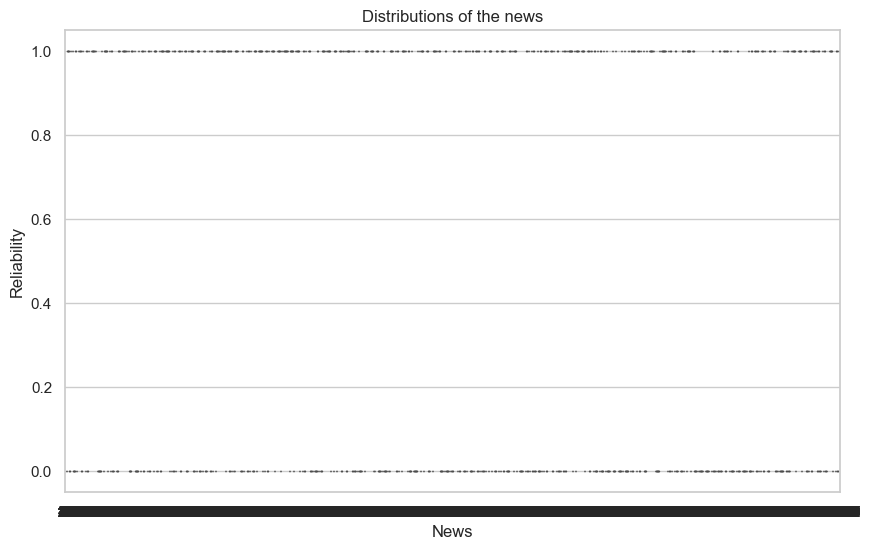

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Stile della grafica
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x='id', y='label', data=df)
plt.title('Distributions of the news')
plt.ylabel('Reliability')
plt.xlabel('News')
plt.show()

According to the author, using the "text" for our prediction takes a very long time for processing, while using "title" and "author" combined together produces a very good accuracy score.

In [9]:
# merging the authors name and the news title 
df['content'] = df['author'] + ' ' + df['title']
print(df['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


For predict the reliability of a news, being our main variable the "label" enclosing if it is true of fake, we want here to separate it from the rest of the dataset and store them in different variables.

In [10]:
# Separating data and label
X = df.drop(columns = 'label', axis = 1) #axis=0 would drop a row; axis=1 stands for dropping columns
Y = df['label']

print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

Aiming to get the best possible performance from our model, the next step is the Stemming, which is nothing but the process of reducing a word to its root.

e.g.: the words actor, actress, acting ecc... lie all on the same root word "act".

In [11]:
port_stem = PorterStemmer()

def stemming(content):
    '''This function stems the words data containted in the input'''
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

df['content'] = df['content'].apply(stemming)

In [12]:
print(df['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [13]:
# Separating the data and label
X = df['content'].values
Y = df['label'].values


In [14]:
print(X)
print(X.shape)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']
(20800,)


In [15]:
print(Y)
print(Y.shape)

[1 0 1 ... 0 1 1]
(20800,)


Another fundamental step is to convert the textual data stored in the X variables in numerical data that a computer can handle.

In [16]:
# Converting the textual data to numerical data as follow
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210687 stored elements and shape (20800, 17128)>
  Coords	Values
  (0, 267)	0.2701012497770876
  (0, 2483)	0.36765196867972083
  (0, 2959)	0.24684501285337127
  (0, 3600)	0.3598939188262558
  (0, 3792)	0.27053324808454915
  (0, 4973)	0.23331696690935097
  (0, 7005)	0.2187416908935914
  (0, 7692)	0.24785219520671598
  (0, 8630)	0.2921251408704368
  (0, 8909)	0.36359638063260746
  (0, 13473)	0.2565896679337956
  (0, 15686)	0.2848506356272864
  (1, 1497)	0.2939891562094648
  (1, 1894)	0.15521974226349364
  (1, 2223)	0.3827320386859759
  (1, 2813)	0.19094574062359204
  (1, 3568)	0.26373768806048464
  (1, 5503)	0.7143299355715573
  (1, 6816)	0.1904660198296849
  (1, 16799)	0.30071745655510157
  (2, 2943)	0.3179886800654691
  (2, 3103)	0.46097489583229645
  (2, 5389)	0.3866530551182615
  (2, 5968)	0.3474613386728292
  (2, 9620)	0.49351492943649944
  :	:
  (20797, 3643)	0.2115550061362374
  (20797, 7042)	0.21799048897828685
  (2079

Finally, I can start splitting the dataset in training and test data.

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

and let's now start training our model: we are using Logistic Regression to make our good-or-fake-news prediction.

In [18]:
model = LogisticRegression()

model.fit(X_train, Y_train)

LogisticRegression()

Once the Machine Learning (ML) model is trained, we can use it to do our predictions, which - and it's important to stress that here - are based only on our title-author joint X variable. What's nice to see will be also the accuracy score of our ML-prediction, compared with the original values in the labels of the dataset - stored in the Y variable.

In [19]:
# Accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9863581730769231


A good metaphora is the following: suppose to be a student which is preparing for an exam and practicing some questions for it. Of course the exam will contain questions similar to - but still unseen on - what he is preparing on from the book: the former is nothing but the test data, while the latter turns out to be the training data.

In ML actually happens the same: one trains the model with the training data and then one tries to make predictions using the model on the test data.

In [20]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy score of the test data : ', test_data_accuracy)

print('Accuracy score of the prediction, on the form of error : ', abs(test_data_accuracy-training_data_accuracy))

Accuracy score of the test data :  0.9790865384615385
Accuracy score of the prediction, on the form of error :  0.007271634615384603


It can be readily observe the error, estimated as the difference in magnitude of the accuracies on the test and training data, being very small, which corresponds to a very accurate prediction.

It is only left to try to make a prediction!

In [22]:
# Making a predicting system on some particular cases

#for j in range(1,Y.shape[0]); forse è troppo, essendo 20k+

#import random
# Estrai casualmente 5 numeri nel range specificato
#random_numbers = random.sample(range(Y.shape[0]), 5)
#for j in random_numbers:

X_new = X_test[0]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is predicted to be Real')
else:
  print('The news is predicted to be Fake')

# so far we used our trained model to predict the reliability of a news.

# The final step is to compare our result with the test (real) one

print(Y[0])
if Y_test[0]==0:
    print('The news is actually Real')
else:
    print('The news is actually Fake')


[1]
The news is predicted to be Fake
1
The news is actually Fake
